# Visualizing sequential Bayesian learning

In this notebook we will examine the problem of estimation given observed data from a Bayesian perspective.

We start by gathering a dataset $\mathcal{D}$ consisting of multiple observations. Each observation is independent and drawn from a parametric probability distribution with parameter $\mu$. We can thus write the probability of the dataset as $p(\mathcal{D}|\mu)$, which determines how likely it is to observe the dataset. For this reason, $p(\mathcal{D}|\mu)$ is known as the **likelihood** function. 

Furthermore, we believe that the parameter $\mu$ is itself a random variable with a known probability distribution $p(\mu)$ that encodes our prior belief. This distribution is known as the **prior** distribution.

Now we might ask ourselves: at a moment posterior to observing the data $\mathcal{D}$, how does our initial belief on $\mu$? We would therefore like to know what the probability $p(\mu|\mathcal{D})$ is, which is known as the **posterior** distribution. This probability, according to Bayes' theorem, is given by

$$p(\mu|\mathcal{D}) = \frac{p(\mathcal{D}|\mu)p(\mu)}{p(\mathcal{D})}$$

## Flipping coins

Suppose we have a strange coin for which we are not certain about the probability $\mu$ of getting heads with it. We can start flipping it many times, and as we record heads or tails in a dataset $\mathcal{D}$ we can modify our beliefs on $\mu$ given our observations. Given that we have flipped the coins $N$ times, the likelihood of observing $m$ heads is given by the Binomial distribution,

$$\text{Bin}(m|N,\mu)={N\choose k}\mu^m(1-\mu)^{N-m}$$

A mathematically convenient prior distribution for $\mu$ that works well with a binomial likelihood is the Beta distribution,

$$\text{Beta}(\mu|a, b) = \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)}\mu^{a-1}(1-\mu)^{b-1}$$

We said $\mu$ would encode our *prior* belief on $\mu$, so why does it seem that we are choosing a prior for mathematical convenience instead? It turns out this prior, in addition to being convenient, will also allow us to encode a variety of prior beliefs as we might see fit. We can see this by plotting the distribution for different values of $a$ and $b$:

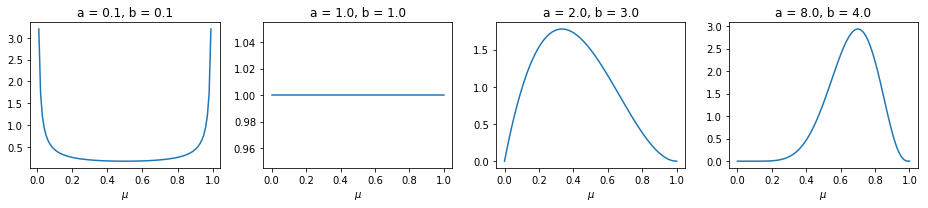

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from scipy.stats import beta

# The set of parameters of the prior to test
a_b_params = ((0.1, 0.1), (1, 1), (2, 3), (8, 4))
mu = np.linspace(0, 1, 100)

# Plot one figure per set of parameters
plt.figure(figsize=(13,3))
for i, (a, b) in enumerate(a_b_params):
    plt.subplot(1, len(a_b_params), i+1)
    
    prior = beta(a, b)
    
    plt.plot(mu, prior.pdf(mu))    
    plt.xlabel(r'$\mu$')
    plt.title("a = {:.1f}, b = {:.1f}".format(a, b))
    plt.tight_layout()

We can see that the distribution is rather flexible. Since we don't know anything about the probability of the coin (which is also a valid prior belief), we can select $a=1$ and $b=1$ so that the probability is uniform in the interval $(0, 1)$.

Now that we have the likelihood and prior distributions, we can obtain the posterior distribution $p(\mu|\mathcal{D})$: the revised beliefs on $\mu$ after flipping the coin many times and gathering a dataset $\mathcal{D}$. In general, calculating the posterior can be a very involved derivation, however what makes the choice of the prior mathematically convenient is that it makes the posterior distribution to be the same: a Beta distribution. A prior distribution is called a **conjugate prior** for a likelihood function if the resulting posterior has the same form of the prior. For our example, the posterior is

$$p(\mu|m, l, a, b) = \frac{\Gamma(m+a+l+b)}{\Gamma(m+a)\Gamma{l+b}}\mu^{m+a-1}(1-\mu)^{l+b-1}$$

where $m$ is the number of heads we observed and $l$ the number of tails (equal to $N-m$).

That's it! Our prior belief is ready and the likelihood of our observations is determined, we can now start flipping coins and seeing how the posterior probability changes with each observation. We will set up a simulation where we flip a coin with probability 0.8 of landing on heads, which is the unknown probability that we aim to find. Via the process of bayesian learning we will discover the true value as we flip the coin one time after the other.

In [3]:
def coin_flip(mu=0.8):
    """ Returns True (heads) with probability mu, False (tails) otherwise. """
    return np.random.random() < mu

# Parameters for a uniform prior
a = 1
b = 1
posterior = beta(a, b)
# Observed heads and tails
m = 0
l = 0

# A list to store posterior updates
updates = []

for toss in range(50):
    # Store posterior
    updates.append(posterior.pdf(mu))
    # Get a new observation by flipping the coin
    if coin_flip():
        m += 1
    else:
        l += 1
    # Update posterior
    posterior = beta(a + m, b + l)

We now have a list, `updates`, containing the values of the posterior distribution after observing one coin toss. We can visualize the change in the posterior interactively using <a href="https://plot.ly/#/" target="_blank">Plotly</a>. Even though there are other options to do animations and use interactive widgets with Python, I chose Plotly because it is portable (Matplotlib's `FuncAnimation` requires extra components to be installed) and it looks nice. All we have to do is to define a dictionary according to the specifications, and we obtain an interactive plot that can be embedded in a notebook or a web page.

In the figure below we will add *Play* and *Pause* buttons, as well as a slider to control playback, which will allow us to view the changes in the posterior distributions are new observations are made. Let's take a look at how it's done.

In [46]:
# Set up and plot with Plotly
import plotly.offline as ply
ply.init_notebook_mode(connected=True)

figure = {'data': [{'x': [0, 1], 'y': [0, 1], 'mode': 'lines'}],
    'layout':
    {
        'height': 400, 'width': 800,
        'xaxis': {'range': [0, 1], 'autorange': False},
        'yaxis': {'range': [0, 8], 'autorange': False},
        'title': 'Posterior distribution',
        'updatemenus':
        [{
            'type': 'buttons',
            'buttons':
            [
                {
                    'label': 'Play',
                    'method': 'animate',
                    'args': 
                    [
                        None,
                        {
                            'frame': {'duration': 500, 'redraw': False},
                            'fromcurrent': True,
                            'transition': {'duration': 0, 'easing': 'linear'}
                        }
                    ]
                },
                {
                    'args':
                    [
                        [None],
                        {
                            'frame': {'duration': 0, 'redraw': False},
                            'mode': 'immediate',
                            'transition': {'duration': 0}
                        }
                    ],
                    'label': 'Pause',
                    'method': 'animate'
                }                
            ]
        }],
        'sliders': [{
            'steps': [{
                'args':
                [
                    ['frame{}'.format(f)],
                    {
                        'frame': {'duration': 0, 'redraw': False},
                        'mode': 'immediate',
                        'transition': {'duration': 0}
                    }
                ],
                'label': f,
                'method': 'animate'
                } for f, update in enumerate(updates)]
        }]
    },
    'frames': [{'data': [{'x': mu, 'y': pu}], 'name': 'frame{}'.format(f)} for f, pu in enumerate(updates)]}

ply.iplot(figure, link_text='')

We can see how bayesian learning allows us to go from a uniform prior distribution on the parameter $\mu$, when there are no observations, and as the number of observations increases, our uncertainty is reduced (which can be seen from the reduced variance of the distribution) and the estimated value centers around the true value of 0.8.

In my opinion, this is a very elegant and powerful method for inference that adequately adapts to a sequential setting as the one we have explored. Even more interesting is the fact that this simple idea can be applied to much more complicated models that deal with uncertainty. On the other hand, we have to keep in mind that the posterior was chosen for mathematical convenience, rather than a selection based on the nature of a particular problem, for which in some cases a conjugate prior might not be the best.